In [1]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import joblib

BASE_DIR = Path.cwd().parent

# Random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# 5. Text‐Embedding–Driven Classification

Welcome back. In our previous notebook, we cleaned and explored a structured dataset sourced from Hugging Face, and built a feature-rich DataFrame (`tf-idf`) tailored for traditional classification models. If you missed it, you can revisit our baseline experiments [here](https://github.com/alikhalajii/text-classification-life-sciences/blob/master/notebooks/04-traning-baseline-models.ipynb).

Now, we shift gears toward embedding-powered classification, where semantic representation meets predictive modeling. This notebook introduces three embedding strategies paired with logistic regression, each offering a distinct balance of speed, expressiveness, and domain adaptability:

- **Word2Vec + LR**  
  - _Fast & Frugal_: A mean-vector approach that’s lightning-fast to train and test.  
  - _Semantic Baseline_: Captures basic word co-occurrence patterns; ideal for testing whether distributional meaning alone adds predictive value.

- **FastText + LR**  
  - _Subword-Aware_: Handles rare terms, typos, and morphological variants via character n-grams.  
  - _Domain Coverage_: Especially useful for Life-Science texts, where specialized jargon often escapes traditional embeddings.

- **SBERT + LR**  
  - _Context-Rich_: Uses transformer-based sentence encoders to grasp word sense, syntax, and subtle linguistic cues.  
  - _High-Quality Embeddings_: Offers deep semantic insight, though at a higher computational cost; serves as a benchmark for simpler models.

Throughout this notebook, we’ll weigh the trade-offs between computational efficiency, vocabulary coverage, and semantic depth to guide our final pipeline design.


## 5.1 Data Preparation & Tokenisation

We begin by loading the annotated dataset of 500 app descriptions, then split it into training and test sets. Each document is tokenised using Gensim's `simple_preprocess`, with standard English stop-words removed to reduce noise.


In [2]:
from sklearn.model_selection import train_test_split
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load the annotated dataset 
df_annotated_full = pd.read_csv(BASE_DIR / "data/02_df_annotated_full.csv")

# Raw texts and labels from the 500 annotated apps
texts  = df_annotated_full["all_text_label"].tolist()
labels = df_annotated_full["Label"].tolist()

# Split into train/test
X_train_txt, X_test_txt, y_train_txt, y_test_txt = train_test_split(
    texts, labels,
    test_size=0.2,
    stratify=labels,
    random_state=SEED
)

# Define stop-words and tokenise
stop_words   = set(ENGLISH_STOP_WORDS)
train_tokens = [
    [t for t in simple_preprocess(doc) if t not in stop_words]
    for doc in X_train_txt
]
test_tokens  = [
    [t for t in simple_preprocess(doc) if t not in stop_words]
    for doc in X_test_txt
]


## 5.2 Word2Vec – Train & Build Document Embeddings

We train a lightweight Word2Vec model on the tokenised training corpus, then create document embeddings by averaging word vectors. This yields fast, stable baselines for downstream classification without heavy compute.


In [3]:
from gensim.models import Word2Vec

# Train Word2Vec on our tokenised training data
w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=SEED
)

# Helper to average word vectors into a single doc vector
def w2v_doc_vector(tokens):
    vecs = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_model.vector_size)

# Create embeddings for train and test sets
X_train_w2v = np.vstack([w2v_doc_vector(toks) for toks in train_tokens])
X_test_w2v  = np.vstack([w2v_doc_vector(toks) for toks in test_tokens])

## 5.3 Word2Vec – Train & Evaluate Logistic Regression

Here, you're pairing your Word2Vec document embeddings with a Logistic Regression classifier for a solid baseline:

**Training**
- `LogisticRegression` is initialized with `max_iter=500` to ensure convergence.
- Model is trained on the averaged Word2Vec vectors (`X_train_w2v`) and labels (`y_train_txt`).

**Saving Components**
- Trained Word2Vec model and classifier are saved using `.gensim` and `joblib` respectively, great for reproducibility and future inference!

**Evaluation**
- Predictions are made on the test set (`X_test_w2v`), and metrics are generated via `compute_metrics`.
- Metrics are printed cleanly in Markdown format.

**Confusion Matrix**
- A visualization is built using `ConfusionMatrixDisplay`, clearly distinguishing "Relevant" vs "Irrelevant" classes.
- Final plot is saved as a high-res PNG for reporting or presentation.


| Model         |   Accuracy % |   Precision % |   Recall % |   F1-score % |
|:--------------|-------------:|--------------:|-----------:|-------------:|
| Word2Vec + LR |           92 |         97.73 |         86 |        91.49 |


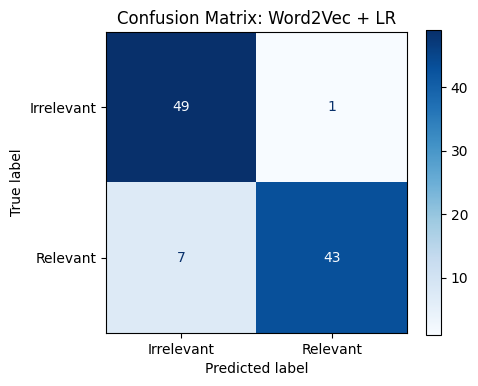

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


# Train classifier
clf_w2v = LogisticRegression(max_iter=500, random_state=SEED)
clf_w2v.fit(X_train_w2v, y_train_txt)

w2v_model.save(str(BASE_DIR / "checkpoints/word2vec_model.gensim"))
joblib.dump(clf_w2v, BASE_DIR / "checkpoints/word2vec_lr.pkl")

# Predict and report metrics
y_pred_w2v = clf_w2v.predict(X_test_w2v)

def compute_metrics(y_true, y_pred, model_name):
    """Compute and return evaluation metrics for a given model."""
    return {
        "Model": model_name,
        "Accuracy %": round(accuracy_score(y_true, y_pred) * 100, 2),
        "Precision %": round(precision_score(y_true, y_pred) * 100, 2),
        "Recall %": round(recall_score(y_true, y_pred) * 100, 2),
        "F1-score %": round(f1_score(y_true, y_pred) * 100, 2),
    }

metrics_w2v = [
    compute_metrics(y_test_txt, y_pred_w2v, "Word2Vec + LR")
]

print(pd.DataFrame(metrics_w2v).to_markdown(index=False))

# Confusion matrix
cm = confusion_matrix(y_test_txt, y_pred_w2v, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Irrelevant","Relevant"])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title("Confusion Matrix: Word2Vec + LR")
plt.tight_layout()
plt.savefig(BASE_DIR / "plots/confusion_matrix_word2vec_lr.png", dpi=150)
plt.show()


## 5.4 FastText – Train & Build Document Embeddings

Next, we train a FastText model over our tokenised corpus. FastText improves on Word2Vec by using subword information, enabling it to handle rare domain terms and unseen tokens more robustly. We then average token vectors to obtain document-level embeddings for classification.


In [5]:
from gensim.models import FastText

# Helper to average FastText vectors into a document vector
def ft_doc_vector(tokens, model, vec_size=100):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(vec_size)

# Train FastText
ft_model = FastText(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=SEED,
    epochs=10
)
ft_model.save(str(BASE_DIR / "checkpoints/fasttext_model.gensim"))

# Create embeddings for train and test sets
X_train_ft = np.vstack([ft_doc_vector(toks, ft_model, vec_size=100) for toks in train_tokens])
X_test_ft  = np.vstack([ft_doc_vector(toks, ft_model, vec_size=100) for toks in test_tokens])


## 5.5 FastText – Train & Evaluate Logistic Regression

We train a Logistic Regression classifier using the FastText-generated document embeddings. This approach helps evaluate how well FastText representations work for text classification.


| Model         |   Accuracy % |   Precision % |   Recall % |   F1-score % |
|:--------------|-------------:|--------------:|-----------:|-------------:|
| FastText + LR |           92 |         95.65 |         88 |        91.67 |


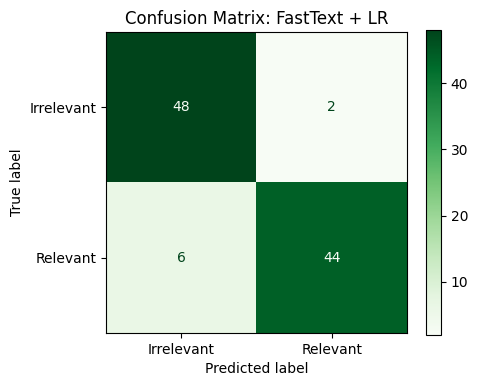

In [6]:
# Train FastText classifier
clf_ft = LogisticRegression(max_iter=1000, random_state=SEED)
clf_ft.fit(X_train_ft, y_train_txt)

# Save LR model
joblib.dump(clf_ft, BASE_DIR / "checkpoints/fasttext_lr.pkl")

# Predict and report metrics
y_pred_ft = clf_ft.predict(X_test_ft)

metrics_ft = [
    compute_metrics(y_test_txt, y_pred_ft, "FastText + LR")
]
print(pd.DataFrame(metrics_ft).to_markdown(index=False))

# Visualizing Confusion Matrix
cm_ft = confusion_matrix(y_test_txt, y_pred_ft, labels=[0,1])
disp_ft = ConfusionMatrixDisplay(cm_ft, display_labels=["Irrelevant","Relevant"])
fig, ax = plt.subplots(figsize=(5,4))
disp_ft.plot(ax=ax, cmap="Greens", values_format="d")
ax.set_title("Confusion Matrix: FastText + LR")
plt.tight_layout()
plt.savefig(BASE_DIR / "plots/confusion_matrix_fasttext_lr.png", dpi=150)
plt.show()


## 5.6 SBERT + Logistic Regression

In this section, we utilize **Sentence-BERT (SBERT)** to embed text descriptions into high-dimensional vector representations. These embeddings are then used to train a **Logistic Regression** classifier for binary relevance classification.



**Embedding Text with SBERT**


In [7]:
from sentence_transformers import SentenceTransformer

sbert = SentenceTransformer("all-MiniLM-L6-v2")
docs = df_annotated_full["all_text_label"].tolist()

embs = sbert.encode(
    docs,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
)

np.save(BASE_DIR / "checkpoints/sbert_embeddings.npy", embs)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

**Train/Test Split**

In [8]:
y = df_annotated_full["Label"]
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    embs, y, stratify=y, test_size=0.2, random_state=SEED
)


**Train Logistic Regression Model**

In [9]:
clf_s = LogisticRegression(max_iter=500, random_state=SEED)
clf_s.fit(X_train_s, y_train_s)

joblib.dump(clf_s, BASE_DIR / "checkpoints/sbert_lr.pkl")


['/home/khalaji/Coding/text-classification-life-sciences/checkpoints/sbert_lr.pkl']

**Predict & Evaluate**

In [10]:
y_pred_s = clf_s.predict(X_test_s)

mettrics_sbert = [
    compute_metrics(y_test_s, y_pred_s, "SBERT + LR")
]

print(pd.DataFrame(mettrics_sbert).to_markdown(index=False))


| Model      |   Accuracy % |   Precision % |   Recall % |   F1-score % |
|:-----------|-------------:|--------------:|-----------:|-------------:|
| SBERT + LR |           90 |         91.67 |         88 |         89.8 |


**Confusion Matrix Visualization**

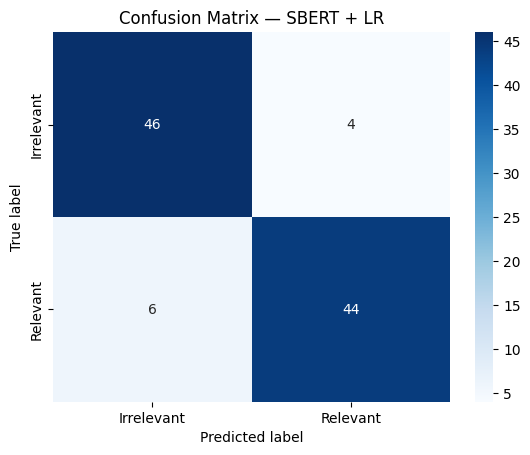

In [11]:
cm = confusion_matrix(y_test_s, y_pred_s)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Irrelevant", "Relevant"],
            yticklabels=["Irrelevant", "Relevant"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — SBERT + LR")
plt.savefig(BASE_DIR / "plots/confusion_matrix_sbert_lr.png", dpi=150)
plt.show()


## 5.7 Visualizing Document Embeddings (PCA)

This section illustrates how document embeddings generated by **Word2Vec** and **FastText** behave in a reduced 2D space using **Principal Component Analysis (PCA)**. Each document is plotted as a point, color-coded by its ground-truth label (Relevant or Irrelevant), providing insight into how well each model separates semantic classes.


**Data Preparation & PCA Transformation**

In [12]:
from sklearn.decomposition import PCA
import plotly.express as px

def make_df(embeddings, labels, model_name):
    df = pd.DataFrame(embeddings, columns=["d1","d2"])
    df["label"] = np.where(labels==1, "Relevant", "Irrelevant")
    df["model"] = model_name
    return df

# Fit PCA on all embeddings
pca = PCA(n_components=2, random_state=SEED)
all_embs = np.vstack([X_train_w2v, X_test_w2v, X_train_ft, X_test_ft])
pca.fit(all_embs)

# Apply PCA transformation
w2v_2d_train = pca.transform(X_train_w2v)
w2v_2d_test  = pca.transform(X_test_w2v)
ft_2d_train  = pca.transform(X_train_ft)
ft_2d_test   = pca.transform(X_test_ft)

**Build DataFrames for Plotting**

In [13]:
df_w2v = make_df(np.vstack([w2v_2d_train, w2v_2d_test]), np.hstack([y_train_txt, y_test_txt]), "Word2Vec")
df_ft  = make_df(np.vstack([ft_2d_train,  ft_2d_test ]), np.hstack([y_train_txt, y_test_txt]), "FastText")
df_plot = pd.concat([df_w2v, df_ft], ignore_index=True)

**Interactive Embedding Visualization**

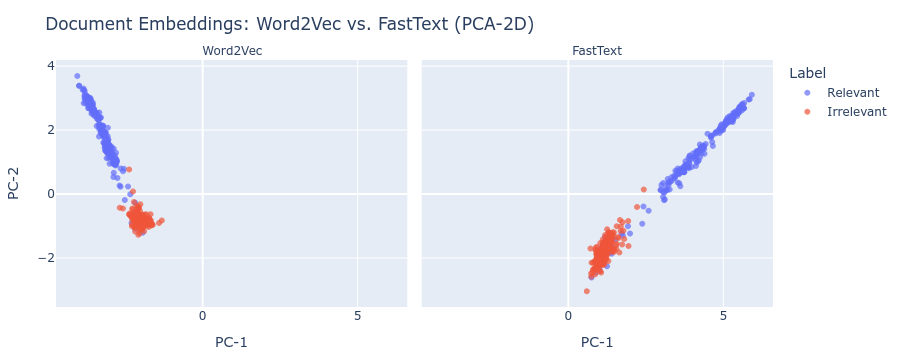

In [14]:
fig = px.scatter(
    df_plot,
    x="d1", y="d2",
    color="label",
    facet_col="model",
    opacity=0.7,
    title="Document Embeddings: Word2Vec vs. FastText (PCA-2D)",
    labels={"d1":"PC-1", "d2":"PC-2"}
)
fig.update_layout(margin=dict(l=20,r=20,t=60,b=20), legend_title="Label")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.write_html(BASE_DIR / "reports/document_EmbeddingsWord2Vecvs.FastText.html", include_plotlyjs="cdn")
fig.show()

## 5.8 Embedding Comparison via UMAP

To better visualize the structure and distribution of document embeddings from different models, we apply **UMAP**—a non-linear dimensionality reduction technique optimized for preserving both global and local data relationships.

**Models Compared**
- Word2Vec + Mean Pooling
- FastText + Mean Pooling
- SBERT (Sentence-BERT)

All three models were trained on **500 manually-labeled samples**, with identical train/test splits. UMAP parameters were carefully tuned (`metric="cosine"`, `n_neighbors=30`, `min_dist=0.1`) to highlight semantic clustering.


**UMAP Visualization Code**

In [15]:
import umap.umap_ as umap

def embed2df(emb, labels, name):
    df = pd.DataFrame(emb, columns=["x", "y"])
    df["Label"] = np.where(labels==1, "Relevant", "Irrelevant")
    df["Model"] = name
    return df

# Initialize UMAP with cosine metric
um = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="cosine", random_state=SEED)

# Stack train/test embeddings for all models
emb_dict = {
    "Word2Vec": np.vstack([X_train_w2v, X_test_w2v]),
    "FastText": np.vstack([X_train_ft, X_test_ft]),
    "SBERT": np.vstack([X_train_s, X_test_s])
}
labels_all = np.hstack([y_train_txt, y_test_txt])

# Transform embeddings and build DataFrames
dfs = []
for name, emb in emb_dict.items():
    coords = um.fit_transform(emb)
    dfs.append(embed2df(coords, labels_all, name))

df_plot = pd.concat(dfs, ignore_index=True)

/home/khalaji/Coding/text-classification-life-sciences/.venv_lf/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



**UMAP Scatterplot (Faceted)**

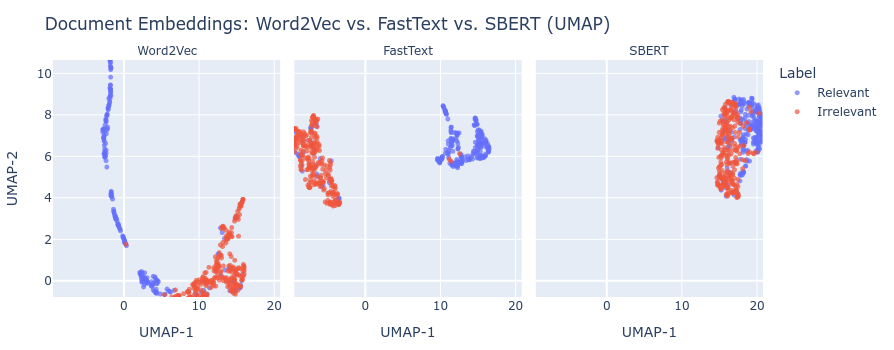

In [16]:
# Axis scaling for comparability
x_min, x_max = df_plot["x"].quantile([0.01, 0.99])
y_min, y_max = df_plot["y"].quantile([0.01, 0.99])

fig = px.scatter(
    df_plot,
    x="x", y="y",
    color="Label",
    facet_col="Model",
    opacity=0.7,
    title="Document Embeddings: Word2Vec vs. FastText vs. SBERT (UMAP)",
    labels={"x": "UMAP-1", "y": "UMAP-2"},
    width=1000, height=350
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_traces(marker=dict(size=5))
fig.update_xaxes(range=[x_min, x_max])
fig.update_yaxes(range=[y_min, y_max])
fig.update_layout(margin=dict(l=20, r=20, t=60, b=20), legend_title="Label")

fig.write_html(BASE_DIR / "reports/embeddings_umap_comparison.html", include_plotlyjs="cdn")
display(fig)


- ***Word2Vec*** shows tighter clusters than PCA, with modest class separation.
- ***FastText*** maintains structural clarity and benefits from subword modeling.
- ***SBERT*** reveals highly compact clusters, reflecting powerful semantic compression.

## 5.9 Summary: Comparing Embedding Models

We evaluated three embedding approaches with logistic regression:
- **Word2Vec**
- **FastText**
- **SBERT**

**Insights from our results and model behavior:**

- **Word2Vec** is simple and fast. It performs reliably and gives decent accuracy, but it lacks deep understanding of rare or out-of-vocabulary terms. Its PCA and UMAP plots showed loose clusters, meaning its representations are more spread out and less precise.

- **FastText** improves on Word2Vec by using subword information. That helps with rare tokens and domain-specific words. It achieved the **highest F1 score**, meaning it's well-balanced for precision and recall. Its visual clusters were tighter than Word2Vec, especially under UMAP.

- **SBERT** doesn't rely on local context or subword tricks; it builds meaning at a sentence level using deep transformers. It produced **the most compact and clear clusters**, indicating strong semantic compression. Despite its lower dimensionality, it performed competitively, showing that deeper models can encode more meaning with fewer features.

- **PCA** gave a rough outline of how embeddings separate classes. **UMAP** gave more detailed insight into how documents relate semantically. SBERT’s tight clusters in both views suggest it builds more consistent meaning across samples.

**Overall takeaway:**  
FastText stands out as a balanced option for strong performance on text classification. SBERT provides deep and efficient semantic mapping,great for tasks where meaning matters more than speed. Word2Vec is still useful for lightweight applications, but it shows limits in expressiveness.



In the [next notebook](https://github.com/alikhalajii/text-classification-life-sciences/blob/master/notebooks/06-ensemble-full-dataset-prediction.ipynb), we take the models trained here and run predictions on the full dataset (~14k rows). The goal is simple: apply our best embeddings and classifiers at scale, compare outputs, and prepare for an ensemble that blends their strengths.
